In [65]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas_ta as ta  # 기술적 지표 라이브러리

In [166]:
class CryptoBacktest:
    def __init__(self, model_path, test_file, initial_balance=10000, trade_ratio=0.1, fee_rate=0.0005, short_term=30, medium_term=60, long_term=120):
        """
        백테스트 초기화
        :param model_path: 저장된 모델 파일 (pkl)
        :param test_file: 테스트 데이터 CSV 파일
        :param initial_balance: 초기 자본금
        :param trade_ratio: 거래 비율 (자본의 몇 %로 매매할지)
        :param fee_rate: 거래 수수료 (0.5% = 0.0005)
        """
        # 모델 불러오기
        with open(model_path, "rb") as f:
            self.model = pickle.load(f)
        
        # 테스트 데이터 로드
        self.df_test = pd.read_csv(test_file, parse_dates=['open_time'], index_col='open_time')

        # 불필요한 컬럼 제거
        self.df_test.drop(columns=['close_time'], inplace=True, errors='ignore')
        if 'Adj Close' not in self.df_test.columns:
            self.df_test['Adj Close'] = self.df_test['close']
        # 기술적 지표 계산
        self.df_test = self.calculate_indicators(self.df_test, short_term=short_term, medium_term=medium_term, long_term=long_term)

        # 기본 설정
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.trade_size = initial_balance * trade_ratio
        self.fee_rate = fee_rate
        self.position = None
        self.trade_log = []
        self.correct_predictions = 0
        self.total_predictions = 0
        self.short_term = short_term
        self.medium_term = medium_term
        self.long_term = long_term

        # 예측 수행
        exclude_cols = ['Label', 'Future_Close', 'Price_Change', 'high', 'open', 'close', 'low']
        features = [col for col in self.df_test.columns if col not in exclude_cols]
        self.X_test = self.df_test[features]
        self.y_pred = self.model.predict(self.X_test)

    def calculate_indicators(self, df, short_term=30, medium_term=60, long_term=120):
        """ 기술적 지표 추가 """
        # WMA
        df['WMA_med'] = df.ta.wma(close=df['Adj Close'], length=medium_term)

        # MACD
        macd_df = df.ta.macd(close=df['close'], fast=short_term, slow=long_term, signal=short_term)
        df[['MACD', 'MACD_signal', 'MACD_hist']] = macd_df

        # RSI
        df['RSI_med'] = ta.rsi(df['close'], length=medium_term)

        # 볼린저밴드
        bbands_med = ta.bbands(df['close'], length=medium_term)
        df[['BBL_med', 'BBM_med', 'BBU_med']] = bbands_med[[f'BBL_{medium_term}_2.0', f'BBM_{medium_term}_2.0', f'BBU_{medium_term}_2.0']]

        # VWAP
        df['VWAP'] = df.ta.vwap(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'])

        # OBV
        df['OBV'] = df.ta.obv(close=df['close'], volume=df['volume'])

        # CMF
        df['CMF_med'] = df.ta.cmf(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=medium_term)

        # NVT Ratio
        df['NVT_Ratio'] = (df['close'] * df['volume']) / df['taker_buy_quote_asset_volume']

        # MVRV Ratio
        df['MVRV_Ratio'] = (df['close'] * df['volume']) / df['taker_buy_base_asset_volume']

        # ADX
        adx_df = ta.adx(df['high'], df['low'], df['close'], length=medium_term)
        df[['ADX_med', 'DMP_med', 'DMN_med']] = adx_df[[f'ADX_{medium_term}', f'DMP_{medium_term}', f'DMN_{medium_term}']]

        # ATR
        df['ATR_med'] = df.ta.atr(high=df['high'], low=df['low'], close=df['close'], length=medium_term)

        # A/D line
        df['ADline'] = df.ta.ad(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'])

        # Stochastic Oscillator
        # so_df = df.ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=medium_term, d=short_term)
        # df[['SO_K_short', 'SO_D_short']] = so_df[[f'STOCHk_{medium_term}_{short_term}_3', f'STOCHd_{medium_term}_{short_term}_3']]
        so_df = df.ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=long_term, d=short_term)
        df[['SO_K_short', 'SO_D_short']] = so_df[[f'STOCHk_{long_term}_{short_term}_3', f'STOCHd_{long_term}_{short_term}_3']]

        df.dropna(inplace=True)
        return df

    def run_backtest(self):
        """백테스팅 실행"""
        take_profit_threshold = 0.001  # +0.5% 익절
        stop_loss_threshold = -0.001   # -0.5% 손절
    
        for i in range(len(self.df_test) - self.medium_term):
            current_price = self.df_test['Adj Close'].iloc[i]
            future_price = self.df_test['Adj Close'].iloc[i + self.medium_term]
    
            # 상승 예측이면 매수 (BUY)
            if self.position is None and self.y_pred[i] == 2:
                self.position = current_price
                fee = self.trade_size * self.fee_rate  # 수수료 차감
                self.balance -= (self.trade_size + fee)  # 매수 금액 + 수수료
                self.trade_log.append((self.df_test.index[i], "BUY", current_price, self.balance))
    
            # 하락 예측이면 즉시 매도 (SELL)
            elif self.position is not None and self.y_pred[i] == 0:
                sell_amount = self.trade_size * (current_price / self.position)  # 매도 후 금액
                fee = sell_amount * self.fee_rate  # 매도 수수료 차감
                self.balance += (sell_amount - fee)  # 매도 금액 - 수수료
                self.trade_log.append((self.df_test.index[i], "SELL", current_price, self.balance))
                self.position = None  # 포지션 종료
    
            # ✅ 익절 / 손절 시스템 적용
            elif self.position is not None:
                price_change = (future_price - self.position) / self.position  # 수익률 계산
    
                if price_change >= take_profit_threshold:  # 익절 조건 (0.5% 이상 상승)
                    sell_amount = self.trade_size * (future_price / self.position)  # 익절 금액
                    fee = sell_amount * self.fee_rate  # 익절 수수료 차감
                    self.balance += (sell_amount - fee)  # 익절 후 잔고 반영
                    self.trade_log.append((self.df_test.index[i], "TAKE-PROFIT", future_price, self.balance))
                    self.position = None  # 포지션 종료
    
                elif price_change <= stop_loss_threshold:  # 손절 조건 (-0.5% 이상 하락)
                    sell_amount = self.trade_size * (future_price / self.position)  # 손절 금액
                    fee = sell_amount * self.fee_rate  # 손절 수수료 차감
                    self.balance += (sell_amount - fee)  # 손절 후 잔고 반영
                    self.trade_log.append((self.df_test.index[i], "STOP-LOSS", future_price, self.balance))
                    self.position = None  # 포지션 종료
    
            # ✅ 예측 정확도 판단
            actual_movement = 2 if future_price > current_price else 0  # 상승(2) / 하락(0)
            if self.y_pred[i] == actual_movement:  # 예측이 맞은 경우
                self.correct_predictions += 1
            self.total_predictions += 1
    
        self.calculate_accuracy()
        self.plot_results()
        self.save_results()
    
        # ✅ 최종 결과 금액 출력
        print(f"원금: ${self.initial_balance:.2f}\n💰 최종 결과 금액: ${self.balance:.2f}")


    def calculate_accuracy(self):
        """예측 정확도 계산"""
        accuracy = (self.correct_predictions / self.total_predictions) * 100 if self.total_predictions > 0 else 0
        print(f"\n📊 예측 정확도: {accuracy:.2f}% ({self.correct_predictions}/{self.total_predictions} 예측 성공)")

    def plot_results(self):
        """잔고 변화 그래프"""
        trade_df = pd.DataFrame(self.trade_log, columns=["Date", "Action", "Price", "Balance"])
        
        plt.figure(figsize=(12, 6))
        plt.plot(trade_df["Date"], trade_df["Balance"], marker="o", linestyle="-", color="blue", label="Balance")
        plt.xlabel("Date")
        plt.ylabel("Balance ($)")
        plt.title("Backtest Result")
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_results(self, filename="backtest_results.csv"):
        """백테스트 결과 CSV로 저장"""
        trade_df = pd.DataFrame(self.trade_log, columns=["Date", "Action", "Price", "Balance"])
        trade_df.to_csv(filename, index=False)
        print(f"✅ 거래 내역이 '{filename}'에 저장되었습니다.")


In [167]:
# 초기 자본을 50,000달러, 거래 비율 20%, 수수료 0.3%로 설정
backtest = CryptoBacktest(
    model_path="crypto_model.pkl",
    test_file="previous_week.csv",
    initial_balance=10000,
    trade_ratio=0.1,
    fee_rate=0.005 
)
backtest_30 = CryptoBacktest(
    model_path="crypto_model_30.pkl",
    test_file="previous_week.csv",
    initial_balance=10000,
    trade_ratio=0.1,
    fee_rate=0.005,
    short_term=15,
    medium_term=30,
    long_term=60
)
backtest_15 = CryptoBacktest(
    model_path="crypto_model_15.pkl",
    test_file="previous_week.csv",
    initial_balance=10000,
    trade_ratio=0.1,
    fee_rate=0.005,
    short_term=7,
    medium_term=14,
    long_term=30
)


📊 예측 정확도: 45.76% (4517/9870 예측 성공)


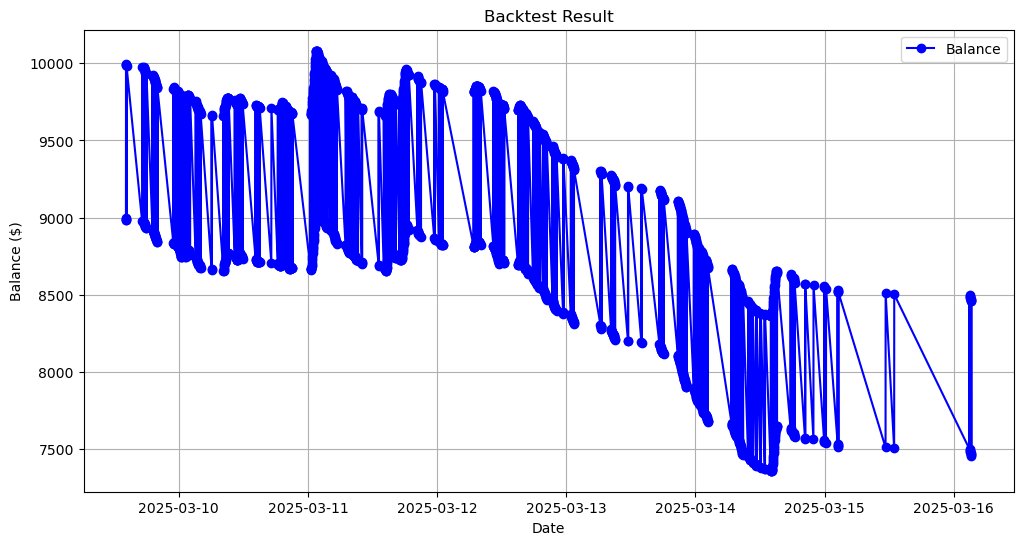

✅ 거래 내역이 'backtest_results.csv'에 저장되었습니다.
원금: $10000.00
💰 최종 결과 금액: $8456.46

📊 예측 정확도: 31.61% (3153/9975 예측 성공)


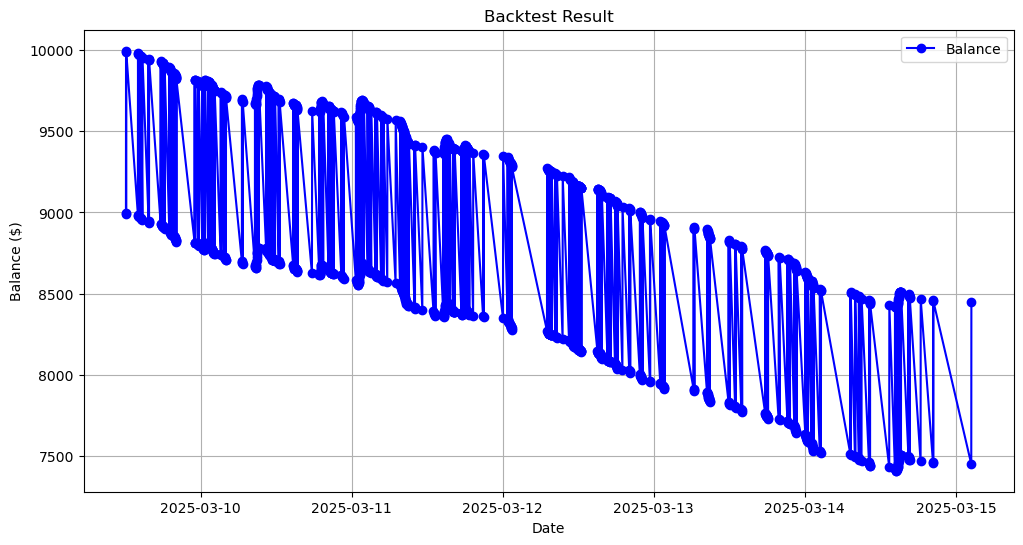

✅ 거래 내역이 'backtest_results.csv'에 저장되었습니다.
원금: $10000.00
💰 최종 결과 금액: $8450.25

📊 예측 정확도: 18.35% (1840/10029 예측 성공)


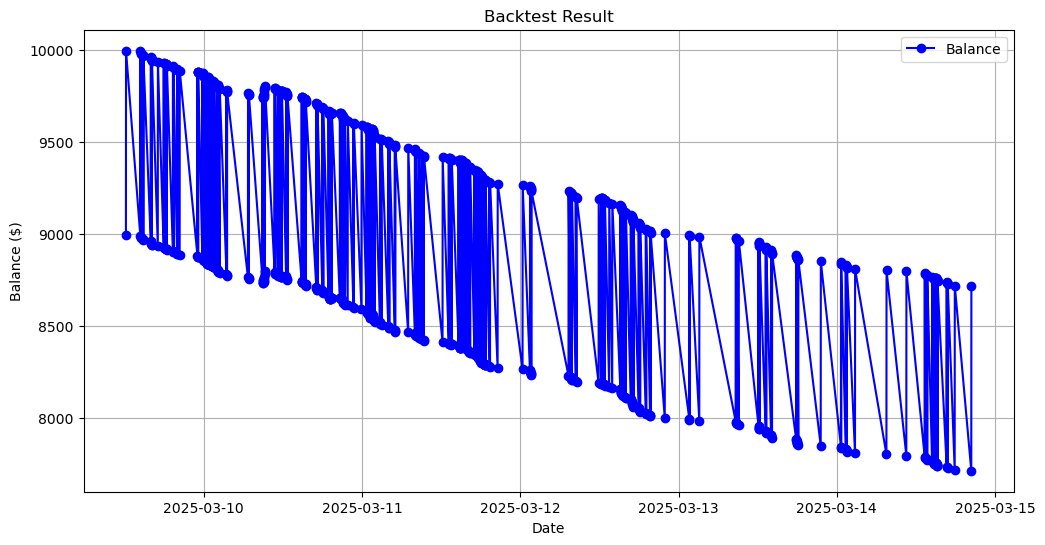

✅ 거래 내역이 'backtest_results.csv'에 저장되었습니다.
원금: $10000.00
💰 최종 결과 금액: $8716.83


In [168]:
backtest.run_backtest()
backtest_30.run_backtest()
backtest_15.run_backtest()

In [169]:
backtest.calculate_accuracy()
backtest_30.calculate_accuracy()
backtest_15.calculate_accuracy()


📊 예측 정확도: 45.76% (4517/9870 예측 성공)

📊 예측 정확도: 31.61% (3153/9975 예측 성공)

📊 예측 정확도: 18.35% (1840/10029 예측 성공)


In [170]:
trade_results = pd.read_csv("backtest_results.csv")
print(trade_results.head(10))  # 상위 10개 거래 내역 출력

                  Date       Action     Price      Balance
0  2025-03-09 12:11:00          BUY  84302.77  8995.000000
1  2025-03-09 12:12:00  TAKE-PROFIT  84646.12  9994.052456
2  2025-03-09 14:22:00          BUY  83283.94  8989.052456
3  2025-03-09 14:23:00  TAKE-PROFIT  83787.32  9990.066378
4  2025-03-09 14:24:00          BUY  83377.99  8985.066378
5  2025-03-09 14:25:00  TAKE-PROFIT  83706.01  9983.980839
6  2025-03-09 14:27:00          BUY  83257.35  8978.980839
7  2025-03-09 14:28:00  TAKE-PROFIT  83483.52  9976.683773
8  2025-03-09 14:47:00          BUY  83314.29  8971.683773
9  2025-03-09 14:48:00  TAKE-PROFIT  83676.92  9971.014565
